## Imports

In [43]:
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

import torch
from torch.distributions import MultivariateNormal
from torch import nn

## Generating data from sin function

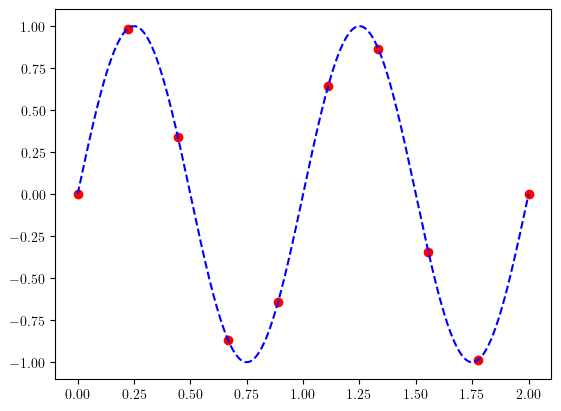

In [44]:
amplitude = 1
period = 2*np.pi
x = torch.linspace(0, 2, 10)
def f(x):
    return amplitude * torch.sin(period * x)

data = f(x)

plt.scatter(x, data, c='r')
plt.plot(torch.linspace(0, 2, 1000) ,f(torch.linspace(0, 2, 1000)), 'b--')
plt.show()

## Gaussian Process Regressor

In [45]:
class RBFKernel(nn.Module):
    def __init__(self, length_scale=1.0, amplitude=1.0):
        super(RBFKernel, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.amplitude = nn.Parameter(torch.tensor(amplitude))
        self.length_scale = nn.Parameter(torch.tensor(length_scale))
        self.lower_bound = torch.tensor([1e-6], device=self.device)
        self.upper_bound = torch.tensor([1e6], device=self.device)
    

    def forward(self, x1, x2):
        x1 = x1.unsqueeze(1)
        x2 = x2.unsqueeze(0)
        amplitude = self.amplitude.clamp(self.lower_bound, self.upper_bound)
        length_scale = self.length_scale.clamp(self.lower_bound, self.upper_bound)

        return amplitude ** 2 * torch.exp(-0.5 * (torch.linalg.norm(x1-x2, dim=2)) / length_scale ** 2)


class GaussianProcessRegressor:
    def __init__(self, kernel, noise=0.0, max_iter=1000, tol=1e-6):
        self.kernel = kernel
        self.noise = noise
        self.max_iter = max_iter
        self.tol = tol
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def fit(self, X, y):
        self.L = None
        self.X_train = X
        self.y_train = y
        optimizer = torch.optim.Adam(self.kernel.parameters(), lr=0.01)

        for i in range(self.max_iter):
            optimizer.zero_grad()
            K = self.kernel(X, X) + self.noise * torch.eye(X.shape[0], device=self.device)
            self.L = torch.linalg.cholesky(K)

            loss = self.neg_log_likelihood(self.L, y)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f'Iteration {i}, Loss: {loss.item()}')
        
        # Compute final Cholesky decomposition of the kernel matrix
        K = self.kernel(X, X) + self.noise * torch.eye(X.shape[0], device=self.device)
        self.L = torch.linalg.cholesky(K)

        return self

            
    
    def neg_log_likelihood(self, L, y):
        mvnormal = MultivariateNormal(torch.zeros(y.shape[0], device=self.device), scale_tril=L)
        return -mvnormal.log_prob(y.squeeze()).sum()
    
    def predict(self, X, num_samples=None, return_std=False):
        K_test = self.kernel(X, self.X_train)
        K_inv = torch.cholesky_inverse(self.L)
        mean = K_test @ K_inv @ self.y_train

        if return_std or num_samples is not None:
            cov = self.kernel(X, X) - K_test @ K_inv @ K_test.T
            cov = cov + 1e-6 * torch.eye(X.shape[0], device=self.device)

        if num_samples is None:
            if return_std:
                return mean, cov.diag().sqrt()
            else:
                return mean
        else:
            mv_normal = MultivariateNormal(mean.squeeze(), covariance_matrix=cov)
            if return_std:
                return mv_normal.sample((num_samples,)), cov.diag().sqrt()
            else:
                return mv_normal.sample((num_samples,))





## Creating Gaussian Process

In [62]:
num_train = 10
x_train = torch.cat([torch.linspace(0, 1, num_train), torch.linspace(1.5, 2, num_train)]).unsqueeze(1).to(torch.device('cuda'))
y_train = f(x_train).to(torch.device('cuda'))

kernel = RBFKernel().to(torch.device('cuda'))
gp = GaussianProcessRegressor(kernel, noise=0.0)

gp = gp.fit(x_train, y_train)

x_test = torch.linspace(-.5, 2.5, 100, device=torch.device('cuda')).unsqueeze(1)

y_pred, y_std = gp.predict(x_test, return_std=True)

Iteration 0, Loss: 9.094459533691406
Iteration 100, Loss: 7.369392395019531
Iteration 200, Loss: 7.071186065673828
Iteration 300, Loss: 7.071168899536133
Iteration 400, Loss: 7.071172714233398
Iteration 500, Loss: 7.071174621582031
Iteration 600, Loss: 7.071176528930664
Iteration 700, Loss: 7.071172714233398
Iteration 800, Loss: 7.071174621582031
Iteration 900, Loss: 7.071176528930664


## Plotting GP Samples

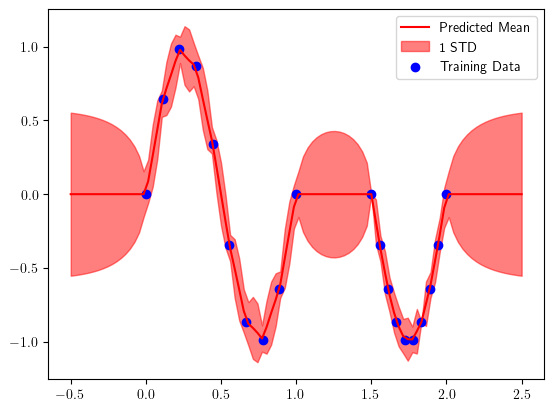

In [63]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

plt.plot(to_numpy(x_test), to_numpy(y_pred), 'r', label='Predicted Mean')

upper = y_pred.squeeze() + 1 * y_std
lower = y_pred.squeeze() - 1 * y_std

plt.fill_between(to_numpy(x_test).squeeze(), to_numpy(upper), to_numpy(lower), alpha=0.5, color='r', label='1 STD')

plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), c='b', label='Training Data')

plt.plot(np.linspace(0, 2, 1000), f(torch.linspace(0, 2, 1000)), 'b--', label='True Function')

plt.legend()

plt.show()